In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pricing_environment import PricingEnvironment
from pricing_agent import SWUCBAgent,CUSUMUCBAgent

In [58]:
n_cust=100
noise=0.1
curve1=lambda p,noise_factor=noise: np.clip(0.95-0.9*p**5+np.random.uniform(-noise_factor,noise_factor),0,1)
curve2=lambda p,noise_factor=noise: np.clip(np.exp(-4*p)+np.random.uniform(-noise_factor,noise_factor),0,1)
curve3=lambda p,noise_factor=noise: np.clip(1-0.4/(1+np.exp(-20*(p-0.2)))-0.5/(1+np.exp(-30*(p-0.6)))+np.random.uniform(-noise_factor,noise_factor),0,1)
curve4=lambda p,noise_factor=noise: np.clip(1-np.tanh(0.75+p**2)+np.random.uniform(-noise_factor,noise_factor),0,1)
norm_dem_curves=[curve1,curve2,curve3,curve4]

Note that all the probabilities are clipped between 0 and 1

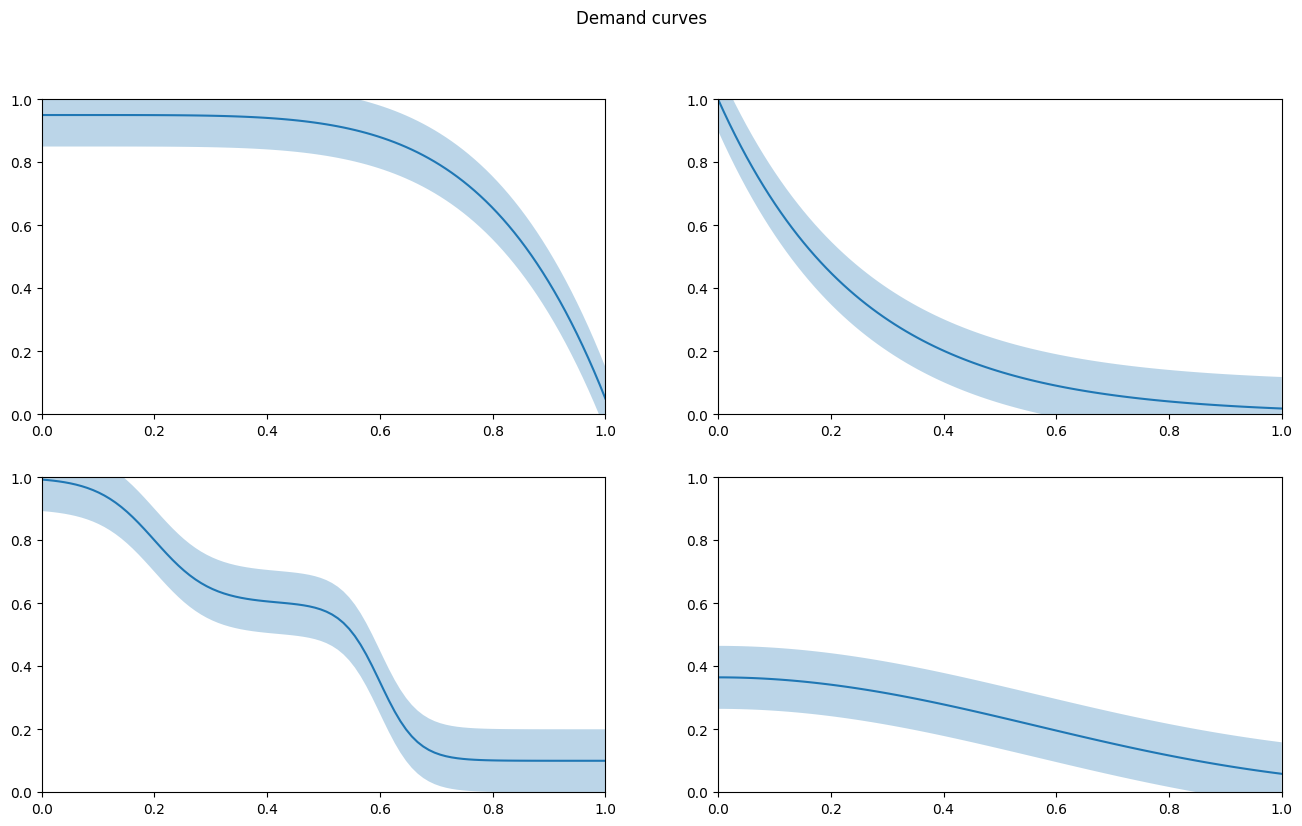

In [59]:
prices=np.linspace(0,1,100)
fig,axs=plt.subplots(2,2,figsize=(16,9))
fig.suptitle('Demand curves')
axs=axs.reshape(-1)
for i in range(len(axs)):
    probs=norm_dem_curves[i](prices,noise_factor=0)
    axs[i].plot(prices,probs)
    axs[i].fill_between(prices,probs-noise, probs+noise, alpha=0.3)
    axs[i].set_ylim(ymin=0,ymax=1)
    axs[i].set_xlim(xmin=0,xmax=1)
    #axs[i].legend()


Best_price for demand curve number 0: 0.7474747474747475
Best_price for demand curve number 1: 0.4545454545454546
Best_price for demand curve number 2: 0.5353535353535354
Best_price for demand curve number 3: 0.6363636363636365


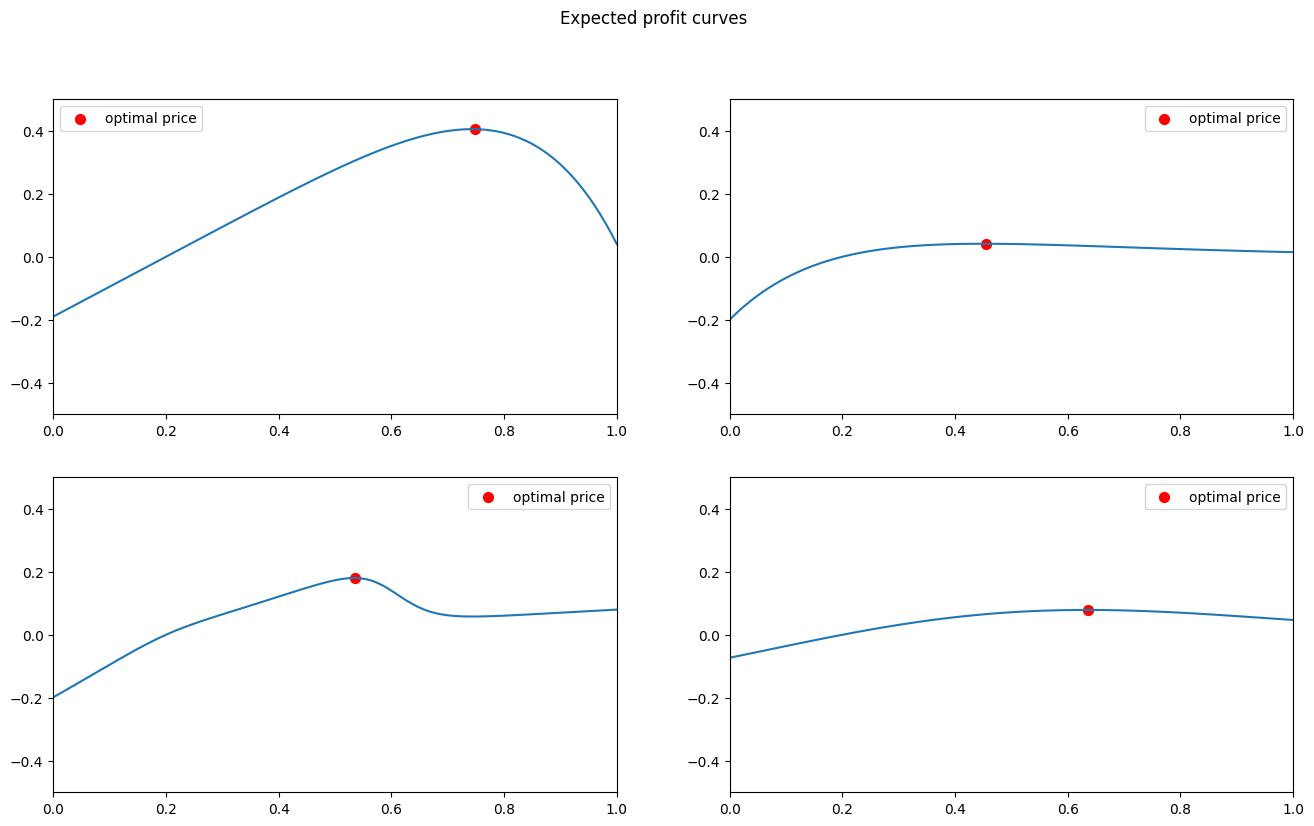

In [60]:
cost=0.2
prices=np.linspace(0,1,100)


fig,axs=plt.subplots(2,2,figsize=(16,9))
fig.suptitle('Expected profit curves')
axs=axs.reshape(-1)
best_prices=[0,0,0,0]
for i in range(len(axs)):
    expected_profit_curve = norm_dem_curves[i](prices,noise_factor=0)*(prices-cost)
    best_price_index = np.argmax(expected_profit_curve)
    best_prices[i] = prices[best_price_index]
    axs[i].plot(prices,expected_profit_curve)
    axs[i].set_ylim(ymin=-0.5,ymax=0.5)
    axs[i].set_xlim(xmin=0,xmax=1)
    axs[i].scatter(best_prices[i], expected_profit_curve[best_price_index], color='red', s=50,label='optimal price')
    axs[i].legend()
    print(f'Best_price for demand curve number {i}: {best_prices[i]}')
#fig.suptitle('Demand curves')


Switching to distribution number 1 in iteration 2500
Switching to distribution number 2 in iteration 5000
Switching to distribution number 3 in iteration 7500


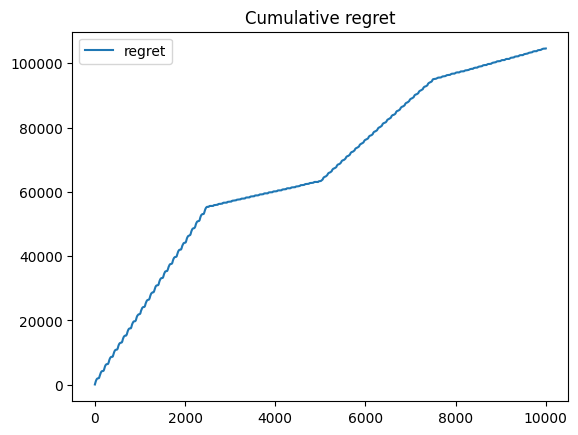

In [61]:
np.seterr('ignore')
T=10000
num_cust=100
discretization=100
prices=np.linspace(0,1,discretization)
indexes=[int(T/4),int(2*T/4),int(3*T/4),T+1]
pulls=np.array([])
rewards=np.array([])
clair_reward=np.array([])
env=PricingEnvironment(norm_dem_curves,cost,indexes)
agent=SWUCBAgent(100,T,int(np.sqrt(T)),prices)

#get clairvoyant
clair_prices=np.zeros(T)
clair_prices[0:indexes[0]]=best_prices[0]
clair_prices[indexes[0]:indexes[1]]=best_prices[1]
clair_prices[indexes[1]:indexes[2]]=best_prices[2]
clair_prices[indexes[2]:indexes[3]]=best_prices[3]



for t in range(T):
    p_t = agent.pull_arm()
    d_t, r_t = env.round(p_t, num_cust,debug=True)
    agent.update(r_t/num_cust)
    rewards = np.append(rewards, r_t)
    pulls=np.append(pulls,p_t)
    dc,rc=env.round(clair_prices[t],num_cust,clairvoyant=True)
    clair_reward = np.append(clair_reward, rc)


    
cum_clair_reward=np.cumsum(clair_reward)
cum_reward=np.cumsum(rewards)
plt.plot(cum_clair_reward-cum_reward,label='regret')
plt.title('Cumulative regret')
plt.legend()
plt.show()

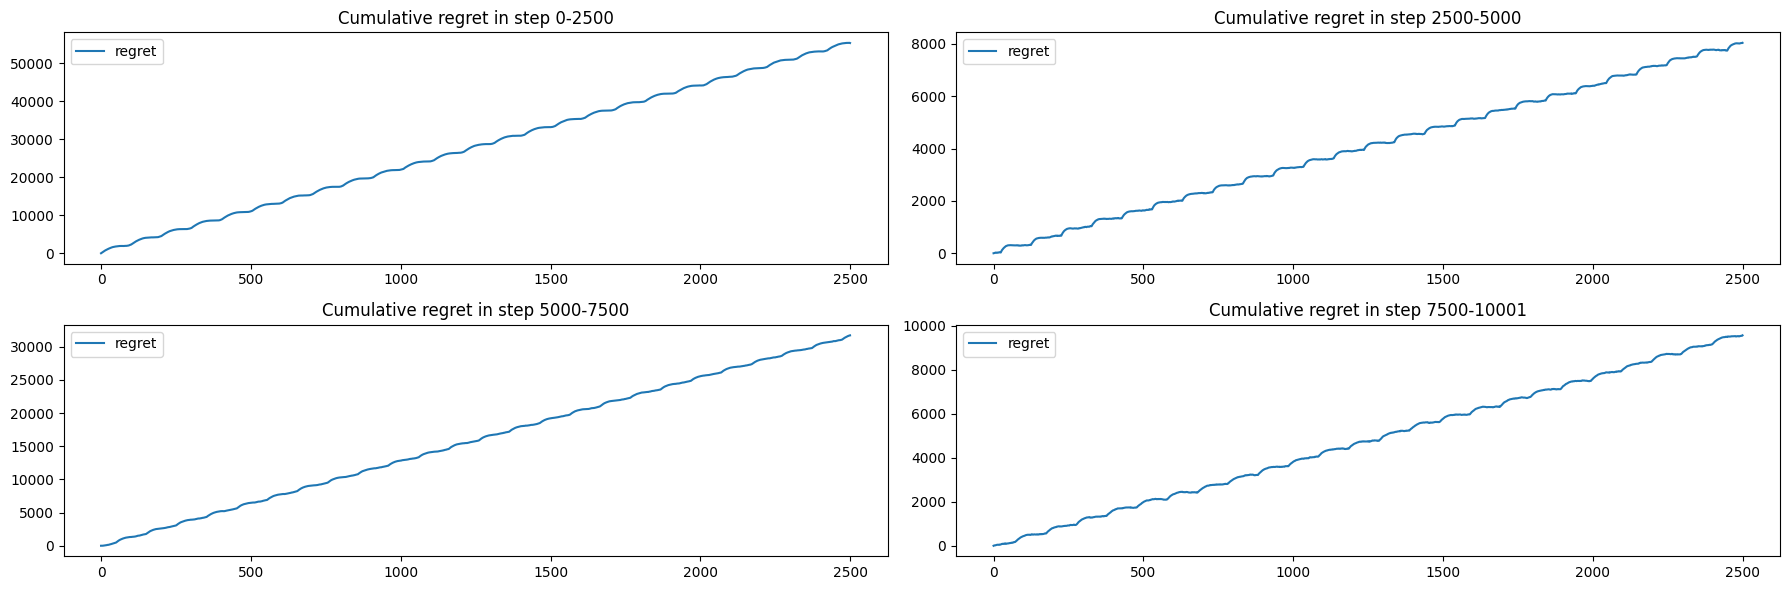

In [62]:
fig,axs=plt.subplots(2,2,figsize=(18,6))
axs=axs.reshape(-1)
idxs=[0,*indexes]
for i in range(len(idxs)-1):
    fraction_clair_reward=np.cumsum(clair_reward[idxs[i]:idxs[i+1]])
    fraction_reward=np.cumsum(rewards[idxs[i]:idxs[i+1]])
    axs[i].plot(fraction_clair_reward-fraction_reward,label='regret')
    axs[i].set_title(f'Cumulative regret in step {idxs[i]}-{idxs[i+1]}')
    axs[i].legend()
fig.tight_layout()
#fig.show()

Switching to distribution number 1 in iteration 2500
Switching to distribution number 2 in iteration 5000
Switching to distribution number 3 in iteration 7500


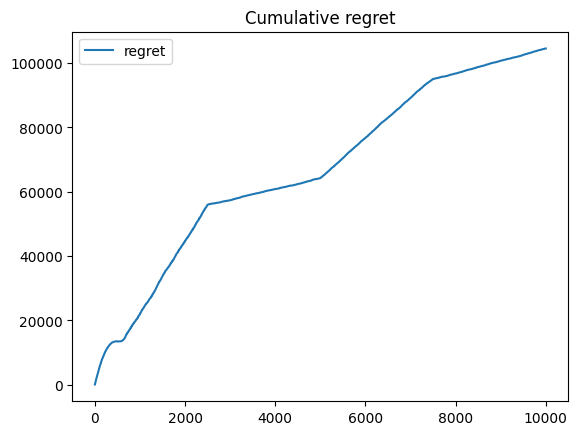

In [63]:
np.seterr('ignore')
T=10000
num_cust=100
discretization=100
prices=np.linspace(0,1,discretization)
indexes=[int(T/4),int(2*T/4),int(3*T/4),T+1]
pulls=np.array([])
rewards=np.array([])
clair_reward=np.array([])
env=PricingEnvironment(norm_dem_curves,cost,indexes)
h = 2*np.log(T/4)
M = int(np.log(T/4))
agent=CUSUMUCBAgent(100,T,M,h,prices)

#get clairvoyant
clair_prices=np.zeros(T)
clair_prices[0:indexes[0]]=best_prices[0]
clair_prices[indexes[0]:indexes[1]]=best_prices[1]
clair_prices[indexes[1]:indexes[2]]=best_prices[2]
clair_prices[indexes[2]:indexes[3]]=best_prices[3]



for t in range(T):
    p_t = agent.pull_arm()
    d_t, r_t = env.round(p_t, num_cust,debug=True)
    agent.update(r_t/num_cust)
    rewards = np.append(rewards, r_t)
    pulls=np.append(pulls,p_t)
    dc,rc=env.round(clair_prices[t],num_cust,clairvoyant=True)
    clair_reward = np.append(clair_reward, rc)


    
cum_clair_reward=np.cumsum(clair_reward)
cum_reward=np.cumsum(rewards)
plt.plot(cum_clair_reward-cum_reward,label='regret')
plt.title('Cumulative regret')
plt.legend()
plt.show()

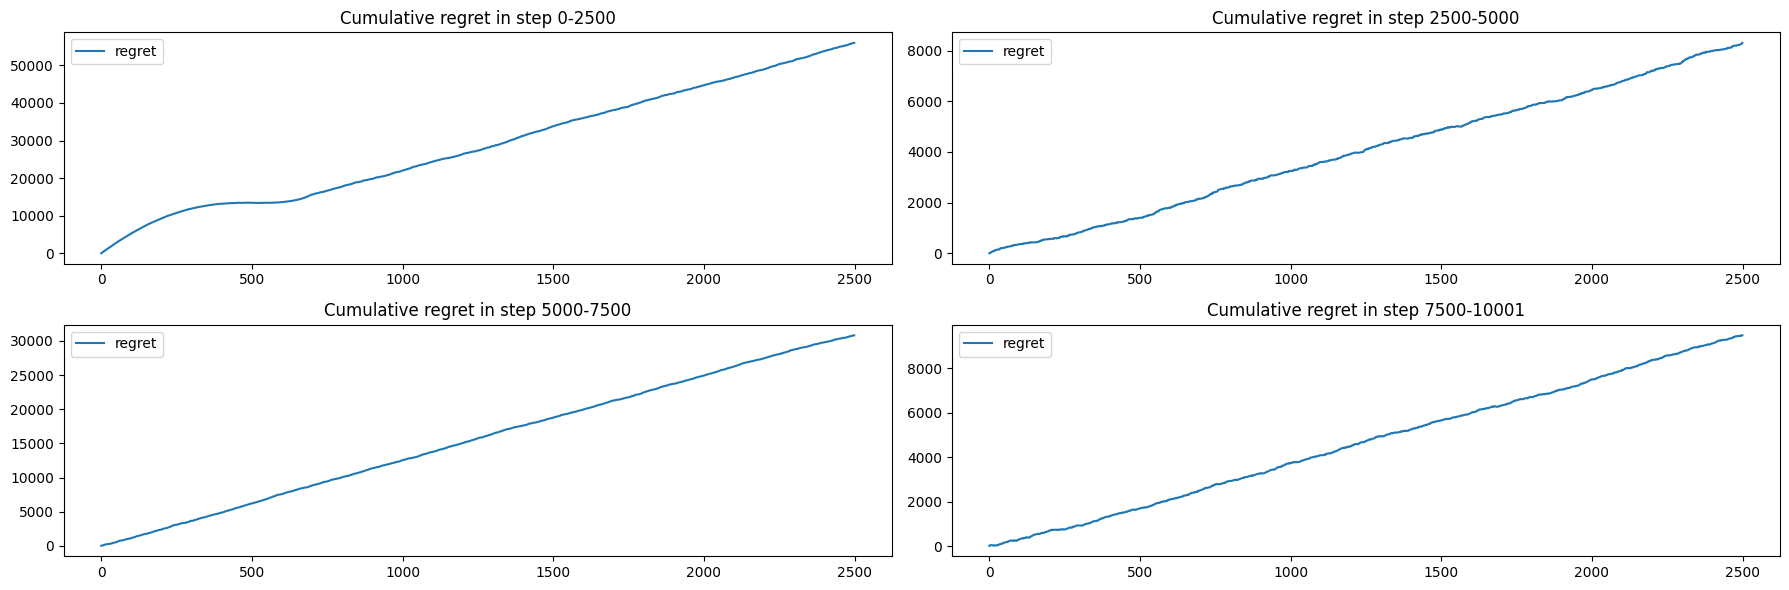

In [64]:
fig,axs=plt.subplots(2,2,figsize=(18,6))
axs=axs.reshape(-1)
idxs=[0,*indexes]
for i in range(len(idxs)-1):
    fraction_clair_reward=np.cumsum(clair_reward[idxs[i]:idxs[i+1]])
    fraction_reward=np.cumsum(rewards[idxs[i]:idxs[i+1]])
    axs[i].plot(fraction_clair_reward-fraction_reward,label='regret')
    axs[i].set_title(f'Cumulative regret in step {idxs[i]}-{idxs[i+1]}')
    axs[i].legend()
fig.tight_layout()
#fig.show()